<a href="https://colab.research.google.com/github/boemer00/stock/blob/main/lstm_model_msft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install --upgrade pandas
# !pip install --upgrade pandas_datareader

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas_datareader as web

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM

In [14]:
df = web.DataReader('MSFT',
                    data_source='yahoo',
                    start='2013-01-01',
                    end='2022-12-13')

In [15]:
df = df[['Close']].tail(1000)
df = df.set_index(pd.to_datetime(df.index))

df.tail()

,Close
Date,
2022-12-07,244.369995
2022-12-08,247.399994
2022-12-09,245.419998
2022-12-12,252.509995
2022-12-13,256.920013


In [16]:
# scale the data
scaler = MinMaxScaler(feature_range=(0,1))
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [17]:
df.head()

,Close
Date,
2018-12-26,0.012861
2018-12-27,0.015384
2018-12-28,0.012169
2018-12-31,0.016971
2019-01-02,0.015140


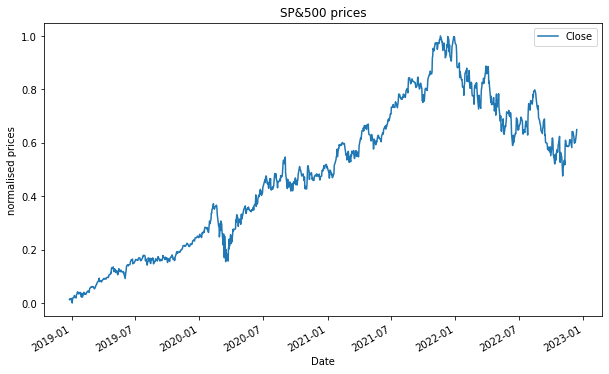

In [18]:
df.plot(figsize=(10,6))
plt.title('SP&500 prices')
plt.ylabel('normalised prices')
plt.show()

In [19]:
def split_sequences(seq, n_steps_in, n_steps_out):
    X = []
    y = []
    
    for i in range(len(seq)):
        end = i+n_steps_in
        out_end = end+ n_steps_out
        
        if out_end > len(seq):
            break
            
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [20]:
def plot_results(results):
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy','accuracy'])
    plt.title('Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.show()

In [21]:
n_per_in = 60   # 30 days past
n_per_out = 10  # 10 days predictions

n_features = 1  # 1 feature (price)

X, y = split_sequences(list(df['Close']), n_per_in, n_per_out)

print(X.shape)

X = X.reshape(X.shape[0], X.shape[1], n_features)

print(X.shape)
print(y.shape)

(961, 30)
(961, 30, 1)
(961, 10)


In [22]:
model = Sequential()
model.add(LSTM(30, activation='softsign', return_sequences=True, input_shape=(n_per_in, n_features)))
model.add(LSTM(20, activation='softsign', return_sequences=True))
model.add(LSTM(10, activation='softsign', return_sequences=True))
model.add(LSTM(10, activation='softsign', return_sequences=True))
model.add(LSTM(10, activation='softsign', return_sequences=True))
model.add(LSTM(10, activation='softsign'))
model.add(Dense(n_per_out))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 30)            3840      
                                                                 
 lstm_7 (LSTM)               (None, 30, 20)            4080      
                                                                 
 lstm_8 (LSTM)               (None, 30, 10)            1240      
                                                                 
 lstm_9 (LSTM)               (None, 30, 10)            840       
                                                                 
 lstm_10 (LSTM)              (None, 30, 10)            840       
                                                                 
 lstm_11 (LSTM)              (None, 10)                840       
                                                                 
 dense_1 (Dense)             (None, 10)               

In [24]:
# compile
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# train
res = model.fit(X, y, batch_size=32, epochs=50)

Epoch 1/50
31/31 [==============================] - 10s 72ms/step - loss: 0.0904 - accuracy: 0.0687
Epoch 2/50
31/31 [==============================] - 2s 72ms/step - loss: 0.0433 - accuracy: 0.0947
Epoch 3/50
31/31 [==============================] - 2s 73ms/step - loss: 0.0096 - accuracy: 0.0822
Epoch 4/50
31/31 [==============================] - 2s 72ms/step - loss: 0.0060 - accuracy: 0.0812
Epoch 5/50
31/31 [==============================] - 2s 71ms/step - loss: 0.0054 - accuracy: 0.0832
Epoch 6/50
31/31 [==============================] - 2s 71ms/step - loss: 0.0058 - accuracy: 0.0812
Epoch 7/50
31/31 [==============================] - 2s 71ms/step - loss: 0.0046 - accuracy: 0.0739
Epoch 8/50
31/31 [==============================] - 2s 75ms/step - loss: 0.0047 - accuracy: 0.0687
Epoch 9/50
31/31 [==============================] - 2s 71ms/step - loss: 0.0051 - accuracy: 0.0853
Epoch 10/50
31/31 [==============================] - 2s 73ms/step - loss: 0.0042 - accuracy: 0.0780
Epoch 11

1/1 [==============================] - 1s 894ms/step
                 Close
2022-12-13  250.979169
2022-12-14  251.579706
2022-12-15  251.555702
2022-12-16  251.509188
2022-12-17  251.288291
2022-12-18  251.853181
2022-12-19  252.165832
2022-12-20  252.760144
2022-12-21  252.106869
2022-12-22  252.567176


<ipython-input-25-41c7c03edfa5>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual = pd.DataFrame(scaler.inverse_transform(df[['Close']].tail(periods)), index = df.Close.tail(periods).index, columns = df.columns).append(preds.head(1))


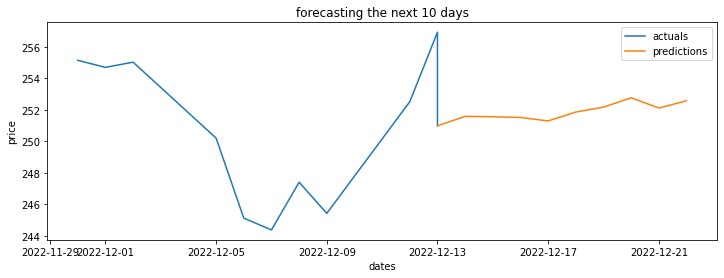

In [25]:
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1,n_per_in,n_features)).tolist()[0]
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat),freq='D'), columns=df.columns)

print(preds)

periods = 10

actual = pd.DataFrame(scaler.inverse_transform(df[['Close']].tail(periods)), index = df.Close.tail(periods).index, columns = df.columns).append(preds.head(1))

plt.figure(figsize=(12,4))
plt.plot(actual, label='actuals')
plt.plot(preds, label='predictions')
plt.ylabel('price')
plt.xlabel('dates')
plt.title(f'forecasting the next {len(yhat)} days')
plt.legend()
plt.show()